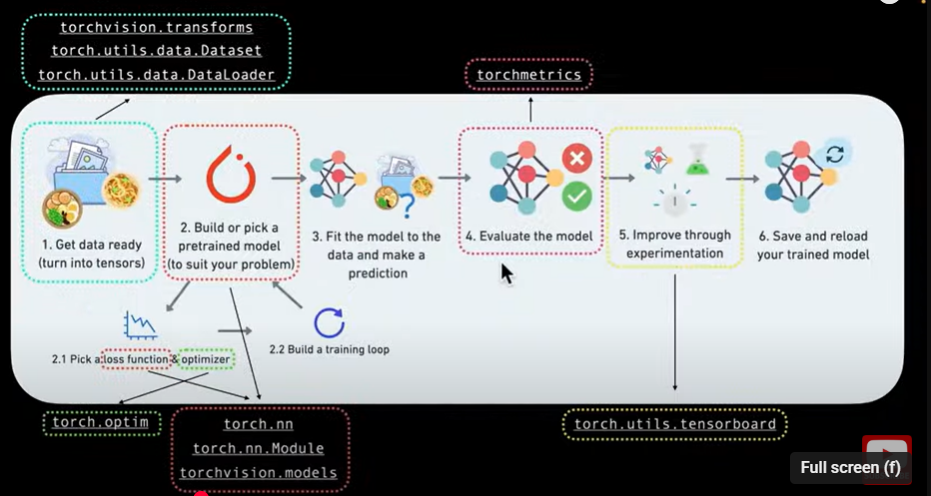

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

In [ ]:
# Linear regression with known parameters

weight = 0.7
bias = 0.3

# Create a range of numbers
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # Matrix
y = (weight * X) + bias

# Inputs and known outputs, our goal is for the model to learn the weights and biases
print(X[:10])
print(y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [ ]:
# Split data into training and test sets, usually 80-20 split

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(X_test))

40 10


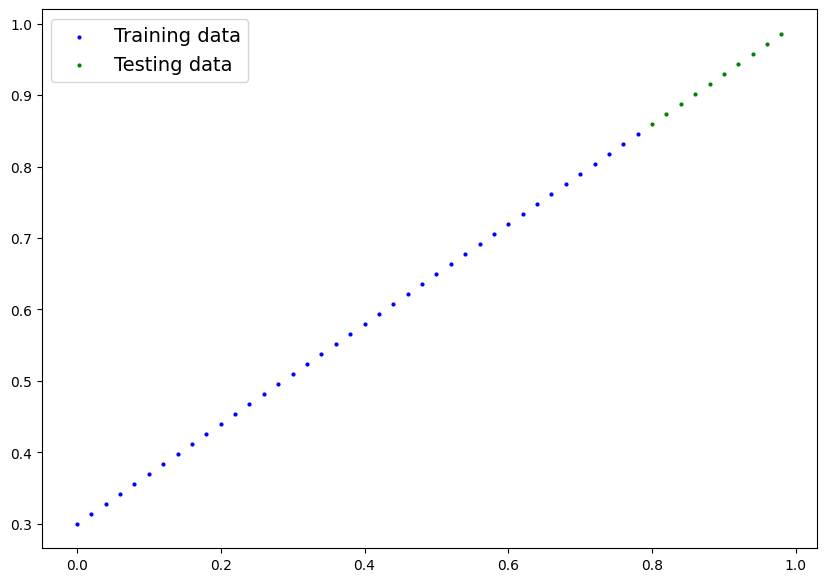

In [ ]:
def plot_preds(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  plt.figure(figsize=(10, 7))

  # Training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot them
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

plot_preds()

In [ ]:
# Regression model class
# Almost everything in PyTorch inherits from nn.Module
# We want to get to the ideal weights and bias with gradient descent over our cost function

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward pass, the computation in the model, required method
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return (self.weights * x) + self.bias

In [ ]:
# Model building essentials

torch.nn # contains all the blocks for computational graphs
torch.nn.Parameter # What parameters our models should learn, a layer will set this for us
torch.nn.Module # Base class for all nns, override forward
torch.optim # Optimizers, helps with gradient descent

# Dataset and Dataloader for data
torch.utils.data.Dataset
torch.utils.data.DataLoader

torch.utils.data.dataloader.DataLoader

In [ ]:
# Checking the contents of the model we made
# We can check whats in the model using .parameters()

torch.manual_seed(22)
model_0 = LinearRegressionModel()

# Print the parameters
print(list(model_0.parameters()))

# List named parameters
print(model_0.state_dict())

[Parameter containing:
tensor([1.0302], requires_grad=True), Parameter containing:
tensor([-0.5073], requires_grad=True)]
OrderedDict([('weights', tensor([1.0302])), ('bias', tensor([-0.5073]))])


tensor([[0.3169],
        [0.3375],
        [0.3581],
        [0.3787],
        [0.3993],
        [0.4199],
        [0.4405],
        [0.4611],
        [0.4817],
        [0.5023]])


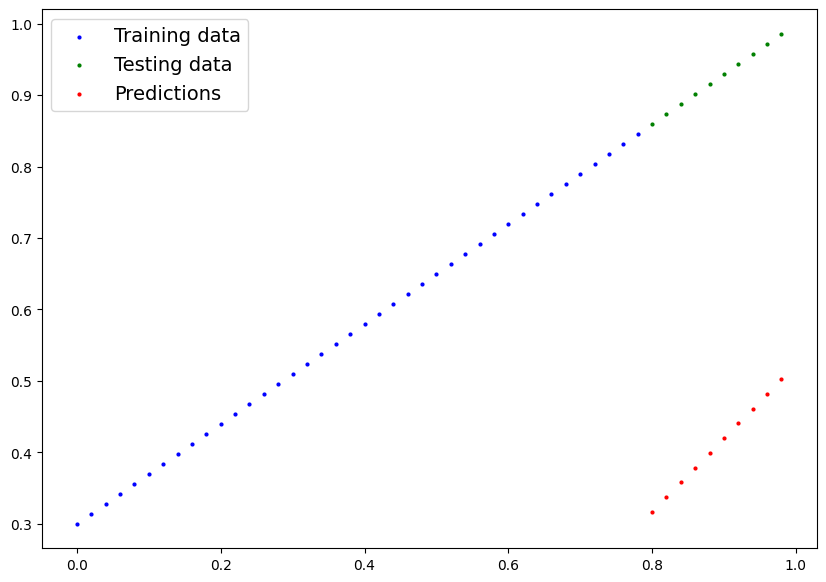

In [ ]:
# Making a preidction using torch.inference_mode()
# Checking y_test based on X_test

with torch.inference_mode(): # This disables the gradient descent
  y_preds = model_0(X_test)

print(y_preds)

# We can see how bad these prediction are right now

plot_preds(predictions=y_preds)

In [ ]:
# Training the model to make better predictions
# Measure how poorly our model is doing using a loss function (single pred)
# A cost function is accross the training set, average loss
# This case we can use mean absolute error -> L1 loss, not L2 (squared) error

# Setup loss and optimizer (most popular is stochastic grad descent)
loss_L1 = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr is the learning rate

In [ ]:
# Building a training and testing loop
# 1. Loop through the data, forward passes (data goes through our forward functions)
# 2. Calculate the loss
# 3. Optimizer zero grad
# 4. Loss backward, calculate the gradients of each parameter with respect to loss
# 5. Optimzer step, use optimizer to adjust parameters

# Set model to training mode as well, the other mode is eval mode

epochs = 10 # 1000

for e in range(epochs):
  model_0.train() # Requires gradients

  # Forward pass
  y_pred = model_0(X_train)

  # Calculate loss
  loss = loss_L1(y_pred, y_train)

  # Zero out the optimizer, so it doesn't accumulate
  optimizer.zero_grad()

  # Backprop on loss wrt. parameters
  loss.backward()

  # Perform gradient descent
  optimizer.step()

  # Testing code
  model_0.eval()
  with torch.inference_mode(): # Turns off gradient tracking and more
    # Forward pass
    test_pred = model_0(X_test)

    # Test loss
    test_loss = loss_L1(test_pred, y_test)

tensor(0.3787)


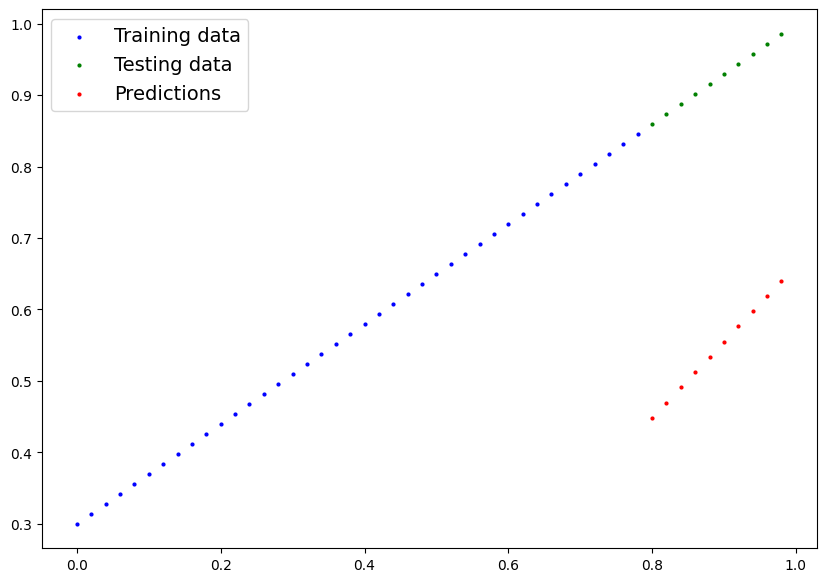

In [ ]:
print(test_loss)

# The predictions are close
plot_preds(predictions=test_pred)

In [ ]:
# Saving our models

# torch.save(), Saves the model in Python pickle format (serialization format)
# torch.load(), Loads a saved PyTorch object
# torch.nn.Module.load_state_dict(), Loads a models saved state dict
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a models save path
MODEL_NAME = "model1_lin_regression.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model's state dict
torch.save(obj=model_0.state_dict, f=MODEL_SAVE_PATH)

In [ ]:
# Loading our model, which is just the state_dict
# We have to instantiate a new instance of our model class

loaded_model = LinearRegressionModel()

# Load the saved state_dict of model_0
# Fix this

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL builtins.getattr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([getattr])` or the `torch.serialization.safe_globals([getattr])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.